# 이미지를 무작위로 뽑아서 확인해 보겠습니다.


In [44]:
from collections import namedtuple
import json
from os import path
import os
import random
from typing import (
    Any, List, Set, Tuple, Callable, Iterable, Mapping, NewType
)

import matplotlib.pyplot as plt
from PIL import Image, ImageShow, ImageDraw

%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 6]

random.seed()


`json` 애노테이션을 읽어서 이미지 경로와 일치 여부를 먼저 확인하겠습니다.


그전에 일단 경로 확인


In [3]:
print(os.getcwd())
print(os.listdir('dataset'))

/home/elice/project-cyberdyne/ai
['validation-labels-src', 'training-labels-src', 'training', 'NanumGothic.ttf', 'validation']


라벨을 읽어서 매치되는 이미지가 없으면 표시합니다.


`*_images` 형식은 아래와 같이 할 계획입니다.

```py
box = tuple[tuple[int, int], tuple[int, int]]
List[tuple[pathname, List[box]]]
```


가끔 폴리곤이란 녀석들이 있어서 변환 함수가 필요합니다.


In [21]:
Box = NewType('Box', Tuple[Tuple[int, int], Tuple[int, int]])

def polygon_to_box(
    verts: Iterable[Mapping[str, str]], res: Tuple[int, int]
) -> Box:
    '''``POLYGON`` 타입 드로잉을 ``BOX`` 형식으로 변환해 반환합니다.'''
    as_nums = [
        tuple(map(int, list(vert.values())[0].split(','))) for vert in verts
    ]
    box = (
        (
            round(640 * min(x for x, y in as_nums) / res[0]),
            round(640 * min(y for x, y in as_nums) / res[1]),
        ),
        (
            round(640 * max(x for x, y in as_nums) / res[0]),
            round(640 * max(y for x, y in as_nums) / res[1]),
        ),
    )
    return box


In [26]:
ImageInfo = namedtuple('ImageInfo', ['path', 'boxes'])

def get_imageinfo(top: str) -> List[ImageInfo]:
    images = []

    for stem, branches, leaves in os.walk(top):
        for leaf in leaves:
            if path.splitext(leaf)[1].lower() == '.json':
                pathname = path.join(stem, leaf)
                json_in = open(pathname, 'r', encoding='utf-8')
                label = json.load(json_in)

                # 이미지 상대 경로를 구합니다.
                prefix = path.dirname(path.relpath(pathname, top))
                image_path = path.join(prefix, label['FILE NAME'])

                # 박스 리스트를 만듭니다.
                res = tuple(map(int, label['RESOLUTION'].split('*')))
                boxes = []
                for box_n in range(int(label['BoundingCount'])):
                    boxinfo = label['Bounding'][box_n]
                    if boxinfo['Drawing'] == 'POLYGON':
                        box = polygon_to_box(boxinfo['PolygonPoint'], res)
                    else:
                        box = (
                                round(640 * int(boxinfo['x1']) / res[0]),
                                round(640 * int(boxinfo['y1']) / res[1]),
                                round(640 * int(boxinfo['x2']) / res[0]),
                                round(640 * int(boxinfo['y2']) / res[1]),
                        )
                    boxes.append(box)

                images.append(ImageInfo(image_path, boxes))

    return images

In [27]:
train_images = get_imageinfo('./dataset/training-labels-src')
val_images = get_imageinfo('./dataset/validation-labels-src')

이미지가 실제로 있는지 확인해 보겠습니다. 하나는 이미 알고 있습니다.


In [28]:
train_images_missing = set()
for imageinfo in train_images:
    pathname = path.join('./dataset/training', imageinfo.path)
    if not path.exists(pathname):
        # print(pathname)
        train_images_missing.add(imageinfo.path)

val_images_missing = set()
for imageinfo in val_images:
    pathname = path.join('./dataset/validation', imageinfo.path)
    if not path.exists(pathname):
        # print(pathname)
        val_images_missing.add(imageinfo.path)


In [29]:
print(len(train_images_missing))
print(len(val_images_missing))


1
0


In [30]:
print(train_images_missing)
print(val_images_missing)

{'캔류/맥주캔/22_X006_C013_1015/22_X006_C013_1015_0.jpg'}
set()


### ~~빠진 파일들~~

~~라벨 -> 이미지 순으로 매치했을 때 빠진 파일이 엄청나게 많다는 것을 알았습니다.~~

~~빠진 파일은 training 에서 27000개, validation 에서 14000 개 가량입니다.~~

- ~~training: 의류/외투, 상의, 하의~~
- ~~validation: 유리병, 가구류, 나무 (하위는 다양)~~

수정: *상대경로 계산을 잘못해서 그랬던 것 같습니다.*

이미지 -> 라벨 순으로 매치하면 어떤 파일이 빠지는지도 봐야 할 것 같습니다.

혹시 이미지 파일 이름이 그냥 단순하게 틀린 것도 있을지 모릅니다.


In [31]:
def get_missing_json(image_top: str, json_top) -> Set[str]:
    result = set()
    for stem, branches, leaves in os.walk(image_top):
        for leaf in leaves:
            pathname = path.join(stem, leaf)
            rel = path.relpath(pathname, image_top)
            json_path = path.join(
                json_top, path.splitext(rel)[0] + '.Json'
            )
            if not path.exists(json_path):
                result.add(json_path)

    return result


In [32]:
print(os.getcwd())
print(path.exists(
    './dataset/validation/자전거/두발자전거/19_X015_C016_1214/19_X015_C016_1214_3.jpg')
)
print(path.exists(
    './dataset/validation-labels-src/자전거/두발자전거/19_X015_C016_1214/19_X015_C016_1214_3.json')
)
print(os.listdir('./dataset/validation-labels-src/자전거/두발자전거/19_X015_C016_1214'))


/home/elice/project-cyberdyne/ai
True
False
['19_X015_C016_1214_2.Json', '19_X015_C016_1214_4.Json', '19_X015_C016_1214_0.Json', '19_X015_C016_1214_1.Json', '19_X015_C016_1214_3.Json']


확장자를 멍청하게 `Json`으로 해놔서 못찾는 거였습니다.

굳이 확장자 첫글자를 대문자로 해야만 했던 데이터 구축업체가 병신인지,
쓸데없이 파일 경로에 대소문자를 구분하는 유닉스가 병신인지
분간이 잘 안갑니다.

지금은 일단 그냥 넘어갔다가 나중에 전부 확장자를 소문자로 바꾸든지 해야겠습니다.


In [33]:
train_labels_missing = get_missing_json(
    './dataset/training', './dataset/training-labels-src'
)

val_labels_missing = get_missing_json(
    './dataset/validation', './dataset/validation-labels-src'
)

print(len(train_labels_missing))
print(len(val_labels_missing))


0
0


## 이미지 무작위로 뽑기

무작위로 뽑기를 위해 대분류/소분류/전체 등 아무 분류에나 적용할 수 있는 범용성 있는 함수를
하나 만들겠습니다.


### 이미지 로드해서 박스 그려주는 함수



In [51]:
def image_with_box(pathname: str, boxes: Iterable[Box]) -> Image.Image:
    image = Image.open(pathname)
    drawer = ImageDraw.Draw(image)
    colors = {0: (0, 255, 255), 1: (255, 0, 255), 2: (255, 255, 0)}
    for i, box in enumerate(boxes):
        if i in colors:
            color = colors[i]
        else:
            color = tuple(random.randint(0, 255) for _ in range(3))
        # print(box)
        drawer.rectangle(box, outline=color, width=5)

    # debug
    # ImageShow.show(image)

    return image
        

## 샘플링 준비

여러 카테고리를 자유롭게 선택할 수 있으려면 상당히 힘든 작업입니다.


In [35]:
train_images_dict = {imageinfo.path: imageinfo for imageinfo in train_images}
val_images_dict = {imageinfo.path: imageinfo for imageinfo in val_images}

In [36]:
def build_classes(
    top: str, src: Iterable[ImageInfo]
) -> Mapping[str, List[str]]:
    classes = {}
    _classes = os.listdir(top)
    for archclass in _classes[:]:
        _classes.extend(os.listdir(path.join(top, archclass)))

    for classname in _classes:
        classes[classname] = []

    for imageinfo in src:
        for classname in _classes:
            if classname in imageinfo.path:
                classes[classname].append(imageinfo)

    return classes


In [37]:
train_classes = build_classes('./dataset/training', train_images)
val_classes = build_classes('./dataset/validation', val_images)

In [38]:
def sample(
    population: Mapping[str, List[str]], *classes: str, k: int = 9
) -> Iterable[ImageInfo]:
    if len(classes):
        pool = []
        for classname in classes:
            pool.extend(population[classname])
    else:
        pool = (
            population['가구류']
            + population['고철류']
            + population['나무']
            + population['도기류']
            + population['비닐']
            + population['스티로폼']
            + population['유리병']
            + population['의류']
            + population['자전거']
            + population['전자제품']
            + population['종이류']
            + population['캔류']
            + population['페트병']
            + population['플라스틱류']
            + population['형광등']
        )

    return random.sample(pool, k)

### 모든 클래스 리스트

```py
['의류', '자전거', '종이류', '캔류', '비닐', '도기류', '고철류', '스티로폼', '페트병', '전자제품', '형광등', '플라스틱류', '유리병', '가구류', '나무', '외투', '상의', '하의', '합성섬유', '원피스', '면의류', '기타의류', '레깅스', '두발자전거', '세발자전거', '네발자전거', '종이봉투', '신문지', '포장상자', '책자', '음료수곽', '상자류', '노트', '기타', '신발상자', '스팸류', '통조림캔', '맥주캔', '커피캔', '참기름캔', '음료수캔', '봉투', '포장제', '일회용덮개', '리필용기', '에어캡', '과자봉지', '장식품', '그릇류', '항아리', '화분', '받침', '컵', '병', '뚝배기', '주전자', '철옷걸이', '비철금속', '프라이팬', '골프채', '전기프라이팬', '고철', '포장용기', '보호재', '네모트레이', '일회용음료수잔', '프린터', '에어컨', '냉장고', '청소기', '전자레인지', '전기밥솥', '전기다리미', '믹서', '비디오플레이어', '팩시밀리', '전기히터', '오디오', '음식물처리기', '가습기', '공기청정기', '식기건조기', '컴퓨터', 'TV', '이동전화단말기', '연수기', '전기오븐', '하이패스', '전기정수기', '선풍기', '세탁기', '복사기', '콤팩트형', '백열전구', 'LED전구', '직관형', '안정기내장형', '환형', '욕실용품', '대용량플라스틱통', '밀폐용기', '장남감', '바구니', '기타술병', '음료수병', '맥주병', '주방용기', '소주병', '박카스병', '물병', '협탁', '소파', '화장대', '장롱', '의자', '수납장', '침대', '밥상', '서랍장', '책상', '싱크대', '포장재', '주방용품', '액자', '나무행거', '주걱', '도마']
```


### 플롯으로 묶어서 보여주기

화면당 9개 정도면 적당할 것 같습니다.


In [52]:
def show_images(mode: str, *classes: str) -> None:
    '''``mode``는 train, val 중 하나입니다.'''
    fig, ax = plt.subplots(3, 3, figsize=(12, 12))
    # fig.set_size
    if mode == 'train':
        pops = train_classes
        top = './dataset/training'
    elif mode == 'val':
        pops = val_classes
        top = './dataset/validation'
    else:
        raise ValueError('unknown mode')
    images = sample(pops, *classes, k=9)

    for i, imageinfo in enumerate(images):
        image = image_with_box(path.join(top, imageinfo.path), imageinfo.boxes)
        ax[i%3][i//3].imshow(image)

    fig.show()
    

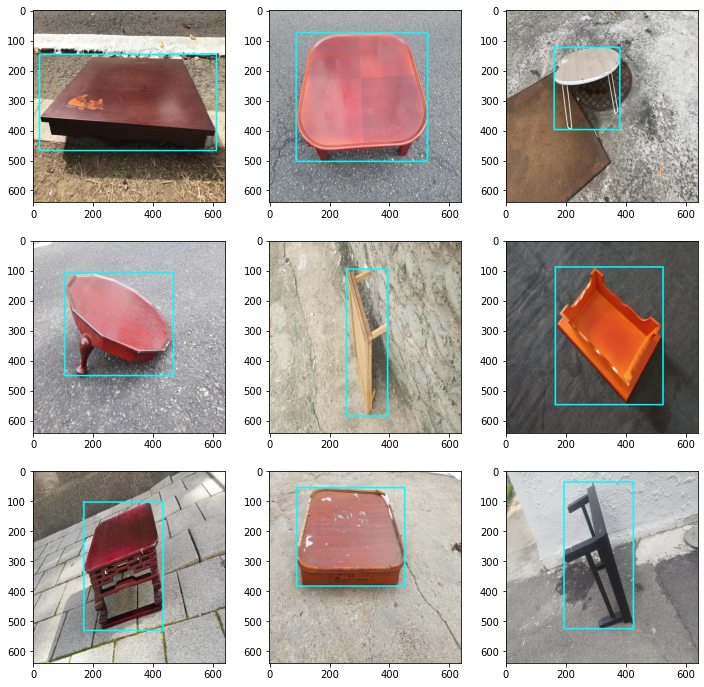

In [53]:
show_images('train', '밥상')